In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 25})
from gradientDescentMeta import ztheta
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GM
from scipy.spatial.distance import braycurtis as bcd
import itertools
from phenotype_constraint import phenotype_constraint
import pickle
from tqdm import tqdm
import json

In [2]:
reduced_metnames = [['Propionate'            ],
    # ['A2BRatio'              ],
    ['Glucose'               ],
    ['NEFA'                  ],
    ['Lactosegkg'            ],
    ['RumenpH'               ],
    ['Starch1'               ],
    ['Valerate'              ],
    ['Lactose'               ],
    ['TotalVFA'              ],
    ['archaea_count_mean'    ],
    ['EnergycorrectedmilkECM'],
    ['Creatinine'            ],
    ['FCM'                   ],
    ['NRC_DMI'               ],
    ['Fat'                   ],
    ['Milk'                  ],
    ['Protein'               ],
    ['DM2'                   ],
    ['Urea'                  ],
    ['Daysinmilk'            ],
    ['gkgECM'                ],
    ['Isobutyrate'           ],
    ['Ammonia'               ],
    ['ECMDMI'                ],
    ['FCEfcm'                ],
    ['Acetate'               ],
    ['FCEecm'                ],
    ['BHB'                   ],
    ['FCEsolids'             ],
    ['Cholesterol'           ],
    ['Butyrate'              ],
    # ['RFINRC'                ],
    ['protozoa_count_mean'   ],
    ['Liveweightkg'          ],
    # ['Haptoglobulin'         ],
    ['Albumin'               ],
    ['Proteingkg'            ],
    ['gkgDMI'                ],
    ['bacteria_count_mean'   ],
    ['gd'                    ],
    ['OM1'                   ],
    ['Fatgkg'                ],
    ['CP1'                   ],
    ['Isovalerate'           ],
    ['NDF1'                  ]]

In [3]:
metadata = np.array(pd.read_csv('data_files/metadata_cow_1.csv', index_col=0))
cow_data = np.array(pd.read_csv('data_files/data_COWS.csv', index_col=0))
metnames = np.array(pd.read_csv('data_files/metnames.csv', index_col=0)).reshape(-1)
metnames = np.array([elem.replace("'", "").strip("[]") for elem in metnames])

metadata = metadata[:, np.isin(metnames, reduced_metnames)]
metnames = metnames[np.isin(metnames, reduced_metnames)]

In [4]:
eta = 0.02
num_steps = 10000
num_latents = 24
alpha = 0.975

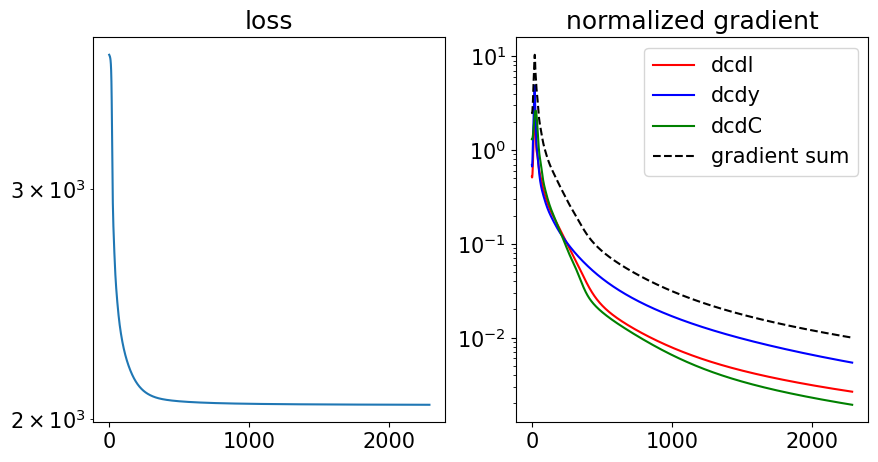

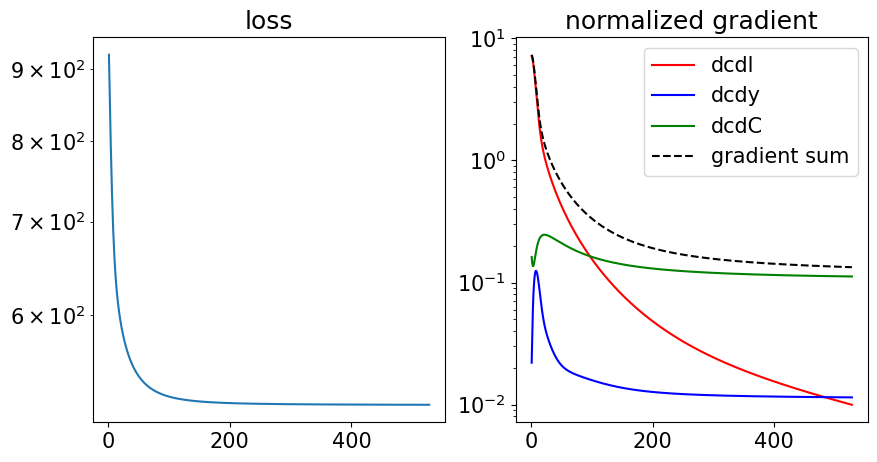

Number of clusters in latents = 2


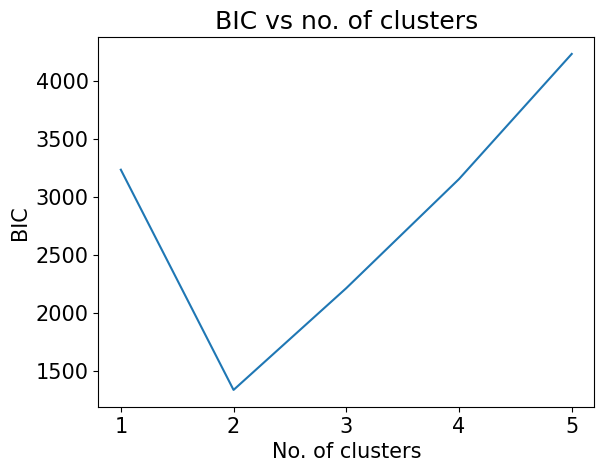

In [5]:
obj = phenotype_constraint(cow_data, metadata, metnames, eta, num_steps, num_latents, alpha)

In [6]:
obj.create_in_silico_samples(cow_data.shape[0])
print(obj.gm_data.shape, obj.gm_meta.shape)

(790, 157) (790, 43)


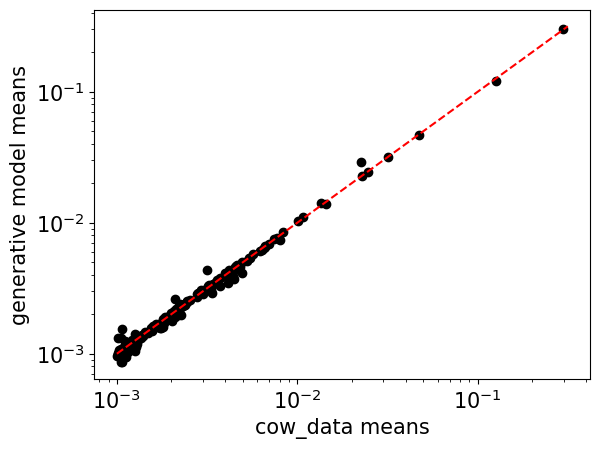

In [7]:
x = np.logspace(-3, -0.5, 100)
plt.plot(x, x, '--', color='red')
plt.scatter(np.mean(cow_data, axis=0), np.mean(obj.gm_data, axis=0), color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cow_data means')
plt.ylabel('generative model means')
# plt.savefig('SI_7_a.pdf', format='pdf')
plt.show()

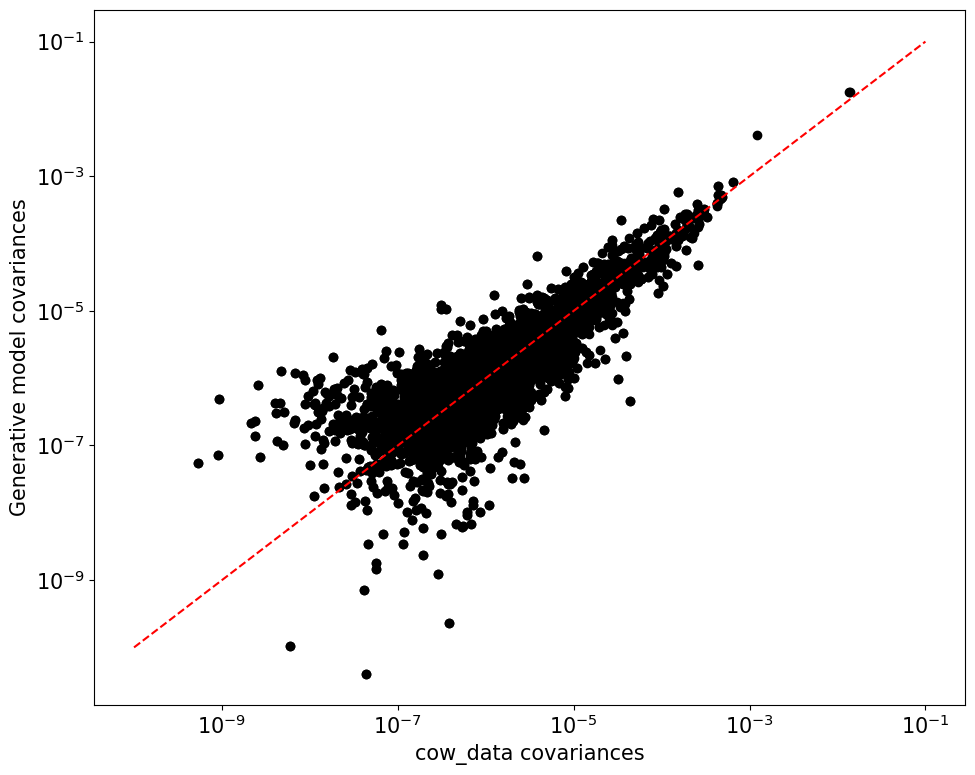

In [8]:
x = np.logspace(-10, -1, 100)
plt.figure(figsize=(10, 8))
plt.plot(x, x, '--', color='red')
plt.scatter(np.cov(cow_data, rowvar=False), np.cov(obj.gm_data, rowvar=False), color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cow_data covariances')
plt.ylabel('Generative model covariances')
# plt.savefig('figures/SI_7_b.pdf', format='pdf')
plt.tight_layout()
plt.show()

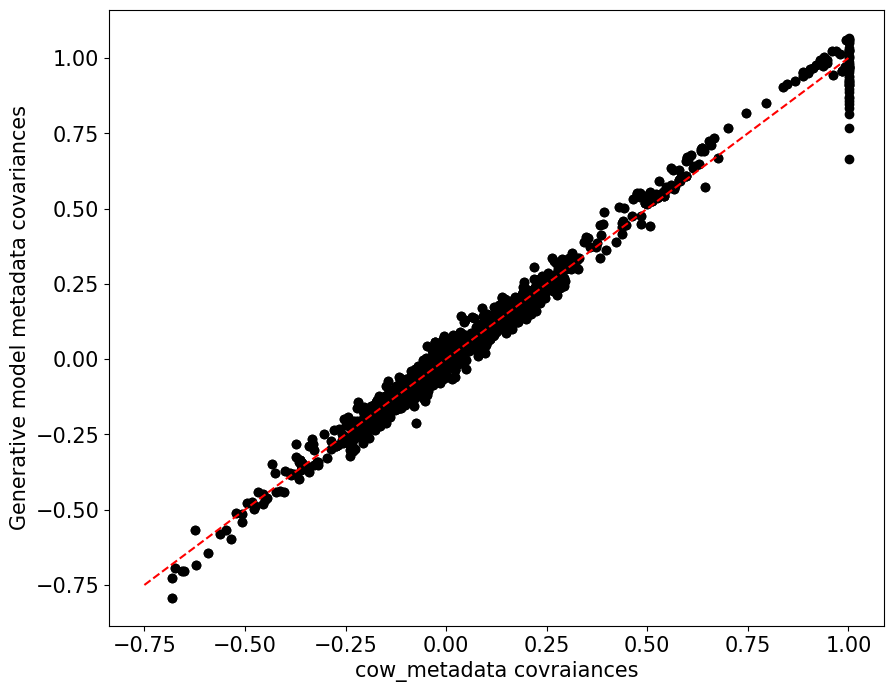

In [9]:
x = np.linspace(-0.75, 1, 100)
plt.figure(figsize=(10, 8))
plt.plot(x, x, '--', color='red')
plt.scatter(np.cov(obj.metadata_z_scored, rowvar=False), np.cov(obj.gm_meta, rowvar=False), color='black')
plt.xlabel('cow_metadata covraiances')
plt.ylabel('Generative model metadata covariances')
# plt.savefig('figures/SI_7_c.pdf', format='pdf')
plt.show()

If the following cell is run with 10 cores, it takes about 25 minutes to run

In [10]:
obj.phenotype_constraint_list(num_cores=10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [17:06<00:00, 102.69s/it]


In [16]:
si_table_1 = {'Phenotypic metadata variables': obj.metadata_names}

df = pd.DataFrame(si_table_1)
# df.to_csv('data_files/si_table_1.csv', index=False)

In [17]:
idxs = np.argsort(obj.constraint_level)[::-1]

si_table_3 = {'Metadata name': obj.metadata_names[idxs], 'Ability to constrain the microbiome (from most to least)': obj.constraint_level[idxs]}

df = pd.DataFrame(si_table_3)
df.head()

,Metadata name,Ability to constrain the microbiome (from most to least)
0,Propionate,0.231844
1,Isobutyrate,0.150645
2,NEFA,0.133037
3,RumenpH,0.130838
4,Glucose,0.128910


In [13]:
# df.to_csv('data_files/si_table_3.csv', index=False)

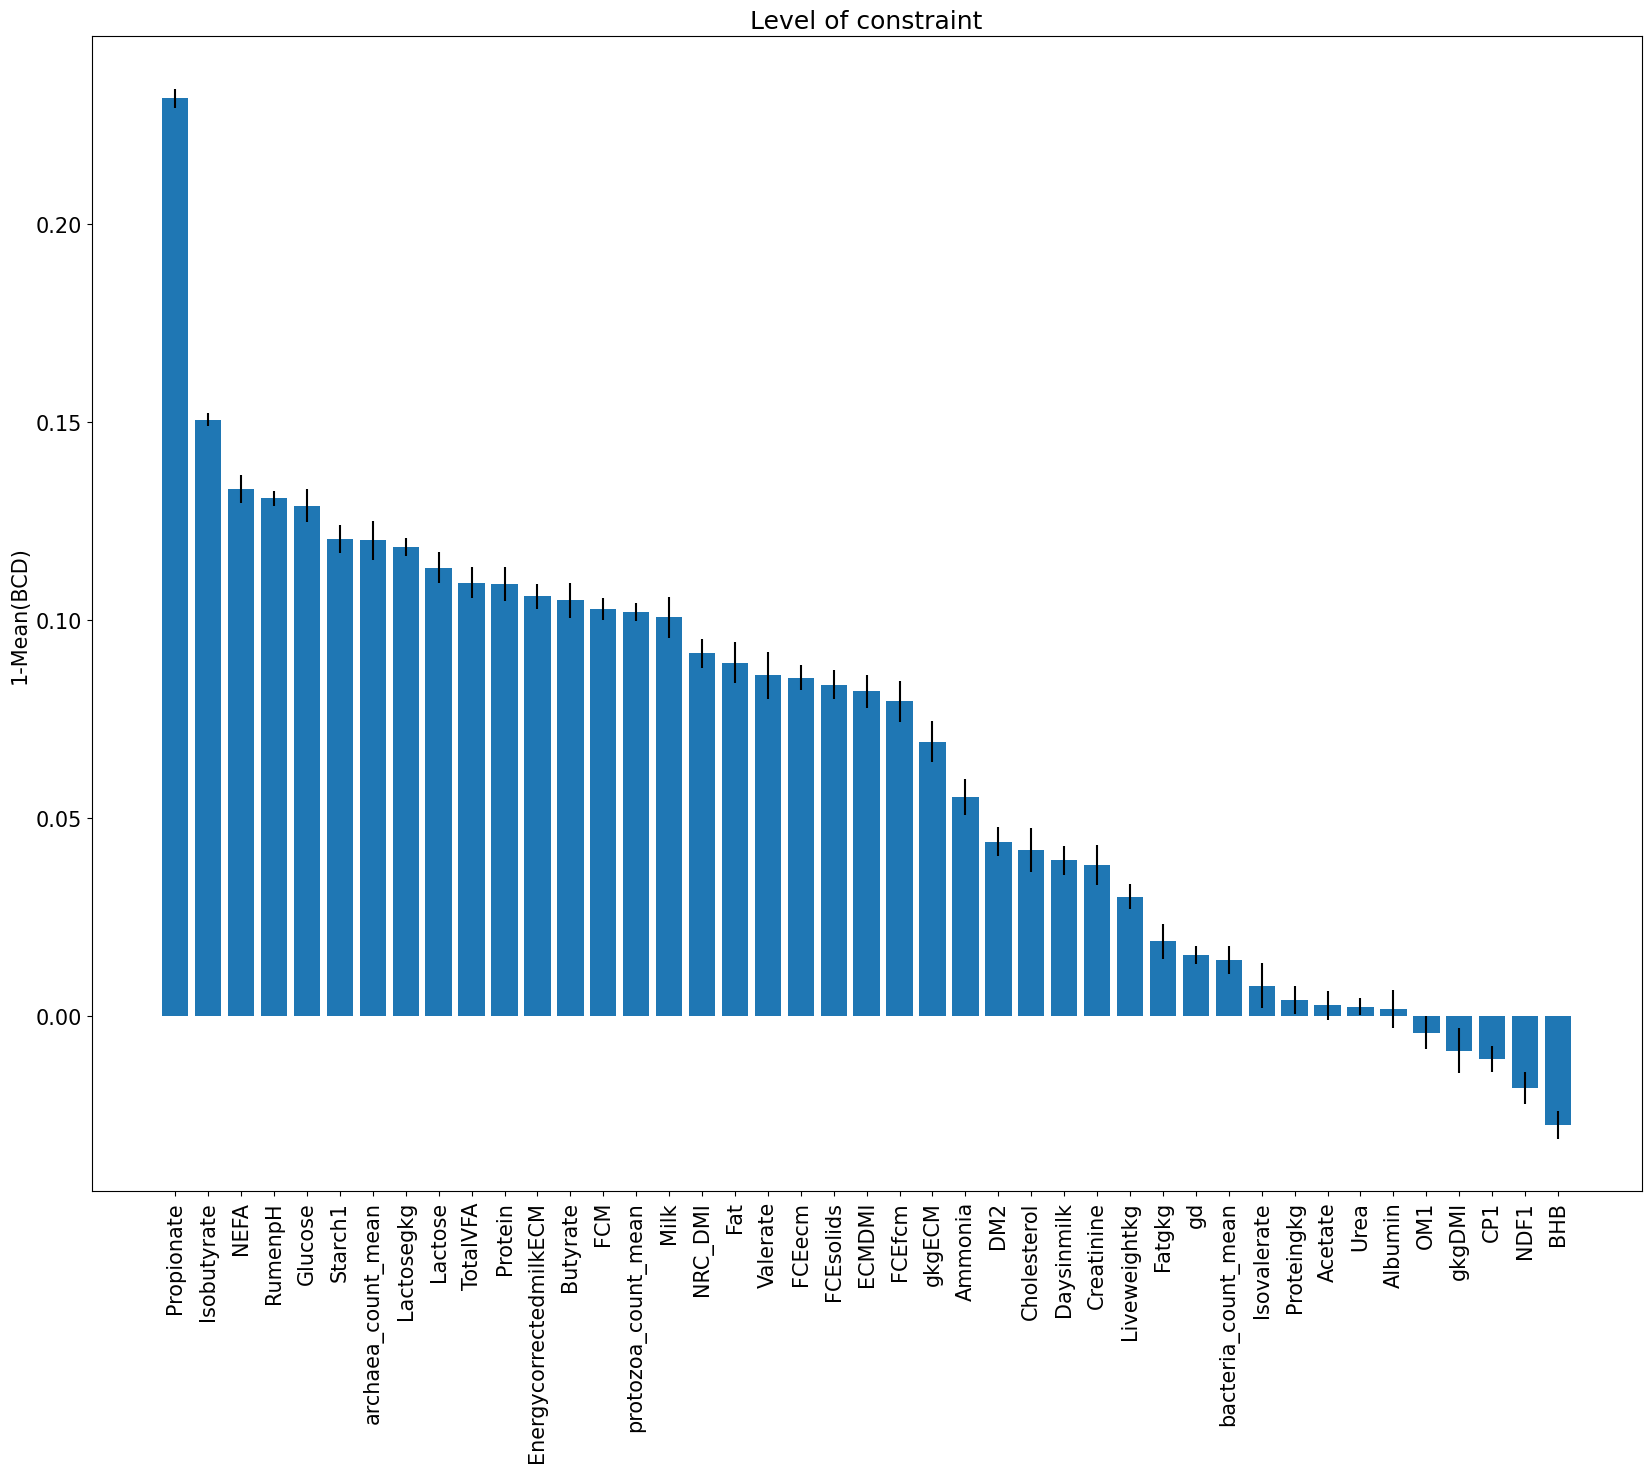

In [18]:
constraint_level_std = np.std(obj.constraint_level_list, axis=0)

idxs = np.argsort(obj.constraint_level)[::-1]
plt.figure(figsize=(20, 15))
# plt.boxplot(np.array(obj.constraint_level_list)[:, idxs])
plt.bar(obj.metadata_names[idxs], np.array(obj.constraint_level)[idxs], yerr=constraint_level_std[idxs])

plt.xticks(rotation=90)
plt.ylabel('1-Mean(BCD)')
plt.title('Level of constraint')
# plt.savefig('figures/SI_table_2.pdf', format='pdf', dpi=300)
plt.show()

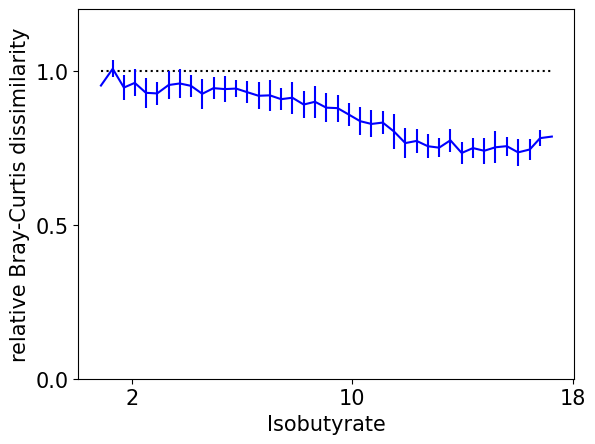

In [20]:
obj.rel_BCD_vs_phenotype('Isobutyrate')
plt.xticks([2, 10, 18])
plt.xlabel('Isobutyrate')
# plt.savefig('figures/fig_3_b.pdf', dpi=300, format='pdf')
plt.show()

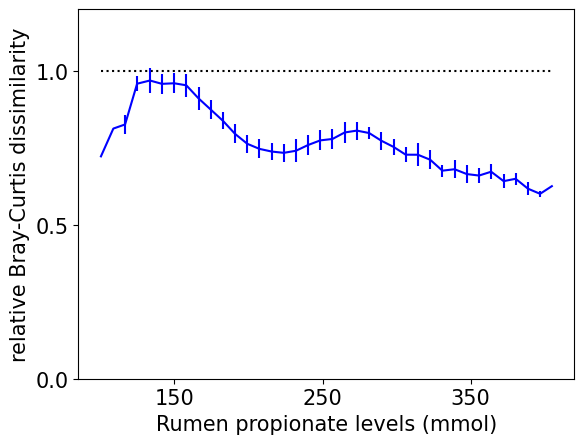

In [21]:
obj.rel_BCD_vs_phenotype('Propionate')
plt.xticks([150, 250, 350])
plt.xlabel('Rumen propionate levels (mmol)')
# plt.savefig('figures/fig_3_a.pdf', dpi=300, format='pdf')
plt.show()

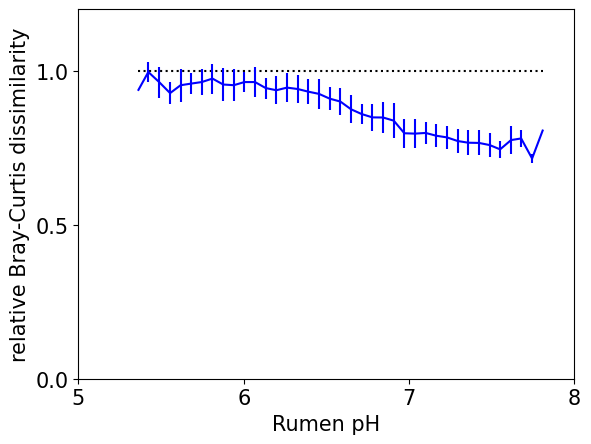

In [22]:
obj.rel_BCD_vs_phenotype('RumenpH')
plt.xticks([5, 6, 7, 8])
plt.xlabel('Rumen pH')
# plt.savefig('figures/fig_3_c.pdf', dpi=300, format='pdf')
plt.show()

### Checkpoint (Save object)

In [12]:
# with open("/home/ks2823/palmer_scratch/my_object.pkl", "wb") as f:
#     pickle.dump(obj, f)

In [ ]:
# with open("/home/ks2823/palmer_scratch/my_object.pkl", "rb") as f:
#     obj = pickle.load(f)

### Warning: The following functions can take a long time to run so instead load the results already computed

In [ ]:
top_3_phen = ['Isobutyrate', 'RumenpH', 'Propionate']
bot_3_phen = ['NDF1', 'CP1', 'BHB']
# The following line can be uncommented and run or the saved files can be loaded

top_3_list, top_3_pred_list = np.array(obj.bcd_constrained_by_meta(top_3_phen))
print('top 3 list computed')
bot_3_list, bot_3_pred_list = np.array(obj.bcd_constrained_by_meta(bot_3_phen))
print('bot 3 list computed')

In [ ]:
num_succesful = len(rng_3_list)
for i in tqdm(range(10)):
    try:
        rng_3_phen = obj.metadata_names[np.random.permutation(len(obj.metadata_names))[:3]]
        rng_3_bcd, rng_3_pred = obj.bcd_constrained_by_meta(rng_3_phen)
        rng_3_list.append(rng_3_bcd)
        rng_3_pred_list.append(rng_3_pred)
        
    except Exception as e:
        print(f"An error occurred: {e}")
        continue
    
    with open('fig_3_files/rng_3_list.json', 'w') as file:
        json.dump(rng_3_list, file)
    with open('fig_3_files/rng_3_pred_list.json', 'w') as file:
        json.dump(rng_3_pred_list, file)
    num_succesful += 1
    print(num_succesful)
rng_3_list = np.array(rng_3_list).reshape(-1)
print('rng 3 list computed')

In [11]:
# with open('fig_3_files/top_3_list.json', 'w') as file:
#     json.dump(top_3_list.tolist(), file)
# with open('fig_3_files/top_3_pred_list.json', 'w') as file:
#     json.dump(top_3_pred_list.tolist(), file)

# with open('fig_3_files/bot_3_list.json', 'w') as file:
#     json.dump(bot_3_list.tolist(), file)
# with open('fig_3_files/bot_3_pred_list.json', 'w') as file:
#     json.dump(bot_3_pred_list.tolist(), file)

# with open('fig_3_files/rng_3_list.json', 'w') as file:
#     json.dump(rng_3_list.tolist(), file)
# with open('fig_3_files/rng_3_pred_list.json', 'w') as file:
#     json.dump(rng_3_pred_list, file)

### Load results

In [11]:
with open('fig_3_files/top_3_list.json', 'r') as file:
    top_3_list = json.load(file)
with open('fig_3_files/top_3_pred_list.json', 'r') as file:
    top_3_pred_list = json.load(file)

with open('fig_3_files/bot_3_list.json', 'r') as file:
    bot_3_list = json.load(file)
with open('fig_3_files/bot_3_pred_list.json', 'r') as file:
    bot_3_pred_list = json.load(file)

with open('fig_3_files/rng_3_list.json', 'r') as file:
    rng_3_list = json.load(file)
with open('fig_3_files/rng_3_pred_list.json', 'r') as file:
    rng_3_pred_list = json.load(file)

### Compute random pair distances

In [12]:
obj.rng_pairs_bcd()

/tmp/ipykernel_28213/3440601034.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([top_3_list, bot_3_list, np.array(rng_3_list).reshape(-1), obj.rng_bcd_list], labels=labels),#


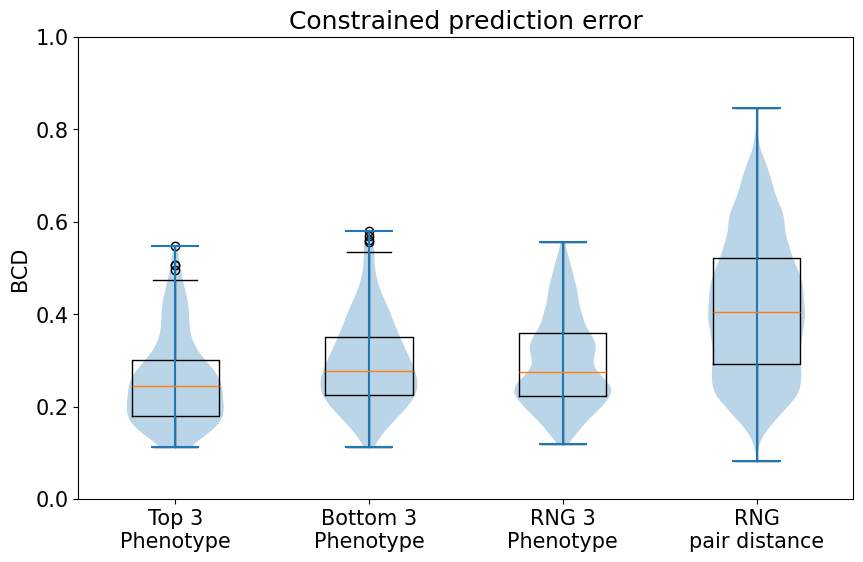

In [13]:
# Define labels
labels = ['Top 3\nPhenotype', 'Bottom 3\nPhenotype', 'RNG 3\nPhenotype', 'RNG\npair distance']

# Create a figure with a broader width
plt.figure(figsize=(10, 6))  # Adjust width and height as needed

# Create boxplot
plt.boxplot([top_3_list, bot_3_list, np.array(rng_3_list).reshape(-1), obj.rng_bcd_list], labels=labels),# 

# Create violin plot
plt.violinplot([top_3_list, bot_3_list, np.array(rng_3_list).reshape(-1), obj.rng_bcd_list]),# 

# Customize plot
plt.ylabel('BCD')
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title('Constrained prediction error')

# Save and show plot
# plt.savefig('figures/fig_3_d.pdf', dpi=300, format='pdf', bbox_inches='tight')  # bbox_inches='tight' ensures the labels are not cut off
plt.show()

In [14]:
from scipy.stats import ttest_ind

In [15]:
t_stat, p_value = ttest_ind(obj.rng_bcd_list, top_3_list)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 13.289310617556835
P-value: 2.889115867842458e-40


In [16]:
t_stat, p_value = ttest_ind(np.array(rng_3_list).reshape(-1), top_3_list)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 4.720812149538884
P-value: 2.537555670678348e-06


In [17]:
t_stat, p_value = ttest_ind(np.array(bot_3_list).reshape(-1), top_3_list)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 3.6736518171412684
P-value: 0.0002810273884963568
